# FIFA Player Ratings Predictor

We're going to try and predict the FIFA player ratings for the next season (2024-2025) using their stats from the previous seasons.

Using performance data from recent seasons, we will apply various machine learning models to identify patterns that best predict future ratings.

Our goal is to provide accurate ratings predictions but also to analyze the effectiveness of different models in capturing the different elements of player performance. We also seek to understand the impact of each feature on the rating.

# Dataset

We're going to use this dataset which contains comprehensive stats for over 2600 players in the 2022/2023:

https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats

As well as this one which contains EA Sports FC 24 Ratings for over 180000 players:

https://www.kaggle.com/datasets/stefanoleone992/ea-sports-fc-24-complete-player-dataset?select=male_players.csv

We need to combine these two datasets so we need to first extract a csv file from the second dataset that only has the 2600 players in the first one.

# Imports

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import pi

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import Pipeline
from pandas.plotting import parallel_coordinates

In [ ]:
fifa= pd.read_csv('male_players.csv', delimiter=";")
#  'utf-8' codec can't decode byte 0xf1 in position 7417: invalid continuation byte
stats= pd.read_csv('/content/2022-2023 Football Player Stats.csv', encoding='latin1', delimiter=";")

# Merging the datasets

Since we're working with two datasets that have different sources and not the same format, the goal of this first part is data cleaning and merging these datasets to obtain a single dataset with all the relevant features.

In [ ]:
# take only ['fifa_version'] == 23.0
fifa= fifa[fifa['fifa_version'] == 24.0]

# drop duplicates
fifa.drop_duplicates(subset='long_name', keep='first', inplace=True)

<ipython-input-122-05bfe5a9e729>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fifa.drop_duplicates(subset='long_name', keep='first', inplace=True)


In [ ]:
fifa

,player_id,player_url,fifa_version,fifa_update,update_as_of,short_name,long_name,player_positions,overall,potential,...,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk,Unnamed: 109
0,231747,/player/231747/kylian-mbappe/240002,24.0,2.0,22/09/2023,K. Mbappé,Kylian Mbappé Lottin,"ST, LW",91,94,...,63+3,63+3,68+3,63+3,54+3,54+3,54+3,63+3,18+3,NaN
1,239085,/player/239085/erling-haaland/240002,24.0,2.0,22/09/2023,E. Haaland,Erling Braut Haaland,ST,91,94,...,63+3,63+3,62+3,60+3,62+3,62+3,62+3,60+3,19+3,NaN
2,192985,/player/192985/kevin-de-bruyne/240002,24.0,2.0,22/09/2023,K. De Bruyne,Kevin De Bruyne,"CM, CAM",91,91,...,80+3,80+3,79+3,75+3,70+3,70+3,70+3,75+3,21+3,NaN
3,158023,/player/158023/lionel-messi/240002,24.0,2.0,22/09/2023,L. Messi,Lionel Andrés Messi Cuccittini,"CF, CAM",90,90,...,63+3,63+3,64+3,59+3,49+3,49+3,49+3,59+3,19+3,NaN
4,165153,/player/165153/karim-benzema/240002,24.0,2.0,22/09/2023,K. Benzema,Karim Benzema,"CF, ST",90,90,...,64+3,64+3,64+3,60+3,55+3,55+3,55+3,60+3,18+3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18345,273759,/player/273759/saphaba-telem/240002,24.0,2.0,22/09/2023,S. Telem,Saphaba Singh Telem,CB,47,57,...,39+2,39+2,41+2,43+2,47+2,47+2,47+2,43+2,13+2,NaN
18346,269013,/player/269013/liangkuan-jin/240002,24.0,2.0,22/09/2023,Jin Liangkuan,金良宽,CB,47,55,...,43+2,43+2,44+2,46+2,47+2,47+2,47+2,46+2,13+2,NaN
18347,272748,/player/272748/mijit-mewlan/240002,24.0,2.0,22/09/2023,M. Mewlan,买乌郎·米吉提,ST,47,55,...,31+2,31+2,35+2,33+2,27+2,27+2,27+2,33+2,13+2,NaN
18348,269534,/player/269534/jie-yin/240002,24.0,2.0,22/09/2023,Yin Jie,尹杰,CM,47,54,...,45+2,45+2,45+2,45+2,44+2,44+2,44+2,45+2,14+2,NaN


In [ ]:
# drop duplicates from the column stats['Player']
stats.drop_duplicates(subset='Player', keep='first', inplace=True)

In [ ]:
stats

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,Off,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.17,2.54,0.51,0.0,0.0,0.00,4.86,0.34,1.19,22.2
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,0.05,0.18,1.59,0.0,0.0,0.00,6.64,2.18,1.23,64.0
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,0.00,1.05,1.40,0.0,0.0,0.00,8.14,0.93,1.05,47.1
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0.00,0.35,0.80,0.0,0.0,0.05,6.60,0.50,0.50,50.0
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,0.00,0.23,2.02,0.0,0.0,0.00,6.51,0.31,0.39,44.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2684,Martín Zubimendi,ESP,MF,Real Sociedad,La Liga,24,1999,19,18,...,0.06,0.11,1.07,0.0,0.0,0.00,6.18,2.19,0.90,70.9
2684,2685,Szymon ?urkowski,POL,MF,Fiorentina,Serie A,25,1997,2,0,...,0.00,2.50,0.00,0.0,0.0,0.00,5.00,2.50,2.50,50.0
2686,2687,Martin Ødegaard,NOR,MF,Arsenal,Premier League,24,1998,20,20,...,0.05,2.51,0.70,0.0,0.0,0.00,5.19,0.48,0.70,40.9
2687,2688,Milan ?uri?,BIH,FW,Hellas Verona,Serie A,32,1990,16,7,...,0.38,0.00,0.13,0.0,0.0,0.00,2.05,14.50,3.59,80.1


In [ ]:
# create a normalized name column in both dataframes
fifa['norm_name'] = fifa['long_name'].str.lower().str.replace(' ', '')
fifa['norm_name'] = fifa['norm_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

stats['norm_name'] = stats['Player'].str.lower().str.replace(' ', '')
stats['norm_name'] = stats['norm_name'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [ ]:
# create a normalized name column in both dataframes without using the middle name
fifa['norm_name_2'] = fifa['long_name'].str.lower().str.split().str[0] + fifa['long_name'].str.lower().str.split().str[-1]
fifa['norm_name_2'] = fifa['norm_name_2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

stats['norm_name_2'] = stats['Player'].str.lower().str.split().str[0] + stats['Player'].str.lower().str.split().str[-1]
stats['norm_name_2'] = stats['norm_name_2'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

In [ ]:
# names from stats that are in fifa norm_name or norm_name_2
stats[stats['norm_name_2'].isin(fifa['norm_name_2'])]

,Rk,Player,Nation,Pos,Squad,Comp,Age,Born,MP,Starts,...,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,norm_name,norm_name_2
0,1,Brenden Aaronson,USA,MFFW,Leeds United,Premier League,22,2000,20,19,...,0.51,0.0,0.00,0.00,4.86,0.34,1.19,22.2,brendenaaronson,brendenaaronson
1,2,Yunis Abdelhamid,MAR,DF,Reims,Ligue 1,35,1987,22,22,...,1.59,0.0,0.00,0.00,6.64,2.18,1.23,64.0,yunisabdelhamid,yunisabdelhamid
2,3,Himad Abdelli,FRA,MFFW,Angers,Ligue 1,23,1999,14,8,...,1.40,0.0,0.00,0.00,8.14,0.93,1.05,47.1,himadabdelli,himadabdelli
3,4,Salis Abdul Samed,GHA,MF,Lens,Ligue 1,22,2000,20,20,...,0.80,0.0,0.00,0.05,6.60,0.50,0.50,50.0,salisabdulsamed,salissamed
4,5,Laurent Abergel,FRA,MF,Lorient,Ligue 1,30,1993,15,15,...,2.02,0.0,0.00,0.00,6.51,0.31,0.39,44.4,laurentabergel,laurentabergel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,2678,Simon Zoller,GER,FW,Bochum,Bundesliga,31,1991,18,16,...,0.15,0.0,0.07,0.00,3.26,0.96,1.26,43.3,simonzoller,simonzoller
2678,2679,Nadir Zortea,ITA,DFMF,Atalanta,Serie A,23,1999,9,1,...,2.00,0.0,0.00,0.00,5.60,2.00,0.40,83.3,nadirzortea,nadirzortea
2680,2681,Kurt Zouma,FRA,DF,West Ham,Premier League,28,1994,15,15,...,0.14,0.0,0.00,0.00,3.94,2.61,0.35,88.1,kurtzouma,kurtzouma
2681,2682,Petar Zovko,BIH,GK,Spezia,Serie A,20,2002,1,0,...,0.00,0.0,0.00,0.00,2.50,0.00,0.00,0.0,petarzovko,petarzovko


In [ ]:
# Subset FIFA to include only the specified features
fifa_subset = fifa[[
    "norm_name_2",  # Include for merging
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed"
]]

# Merge both datasets on 'norm_name_2'
merged = pd.merge(fifa_subset, stats, on='norm_name_2', how='inner')

# Save the merged dataset
merged.to_csv('merged_fifa_stats_24.csv', index=False)

In [ ]:
merged

,norm_name_2,overall,pace,shooting,passing,dribbling,defending,physic,goalkeeping_diving,goalkeeping_handling,...,Crs,TklW,PKwon,PKcon,OG,Recov,AerWon,AerLost,AerWon%,norm_name
0,erlinghaaland,91,89.0,93.0,66.0,80.0,45.0,88.0,7,14,...,0.27,0.05,0.05,0.0,0.0,1.10,1.37,1.26,52.1,erlinghaaland
1,kevinbruyne,91,72.0,88.0,94.0,87.0,65.0,78.0,15,13,...,8.82,0.51,0.06,0.0,0.0,3.71,0.45,0.56,44.4,kevindebruyne
2,karimbenzema,90,79.0,88.0,83.0,87.0,39.0,78.0,13,11,...,0.09,0.34,0.17,0.0,0.0,1.98,0.43,0.43,50.0,karimbenzema
3,robertlewandowski,90,75.0,91.0,80.0,87.0,44.0,84.0,15,6,...,0.68,0.34,0.00,0.0,0.0,1.82,1.49,1.42,51.2,robertlewandowski
4,thibautcourtois,90,NaN,NaN,NaN,NaN,NaN,NaN,85,89,...,0.00,0.00,0.00,0.0,0.0,1.67,0.20,0.00,100.0,thibautcourtois
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1614,davidozoh,56,67.0,48.0,53.0,59.0,53.0,61.0,12,8,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,davidozoh
1615,juliusbeck,56,68.0,50.0,53.0,59.0,54.0,58.0,12,14,...,0.00,10.00,0.00,0.0,0.0,10.00,0.00,10.00,0.0,juliusbeck
1616,mathishamdi,56,61.0,29.0,39.0,49.0,54.0,52.0,8,14,...,10.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,mathishamdi
1617,alanmarcolino,56,59.0,61.0,43.0,53.0,23.0,46.0,6,6,...,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,alandomarcolino


# Loading the dataset
After cleaning our dataset and preparing it for the models, we don't need to re-execute the previous blocks each time, we can simply load it using this block.

In [84]:
# Load the merged dataset
merged = pd.read_csv('merged_fifa_stats_24.csv', delimiter=",")

# Dividing the datasets
Since the FIFA cards for goalkeepers and outfield players are fundmanetally different (their stats are also very different). It would make more sense to divide these datasets in two:

-A dataset containing outfield players.

-A dataset containing goalkeepers.

Actually, our stats dataset doesn't have relevant goalkeeper statistics (like saves, clean sheets, etc.) so for the moment, we can't expect to make predictions about goalkeeper ratings and will stick to only outfield players.


In [85]:
# Isolate goalkeepers
goalkeepers = merged[merged['Pos'] == 'GK']

# Isolate outfield players
outfield_players = merged[merged['Pos'] != 'GK']

# Save the datasets to CSV files
goalkeepers.to_csv("goalkeepers.csv", index=False)
outfield_players.to_csv("outfield_players.csv", index=False)

print("Datasets saved successfully!")

Datasets saved successfully!


# Dataset Exploratory Analysis

Since our stats dataset has a lot of features (+100) we will only pick certain features for the data visualization:

- Scoring and Shooting Metrics
 - **Goals**: Total goals scored, often reflects a player's offensive contributions.
 - **Shots**: Total shots taken, an indicator of attacking involvement.
 - **SoT (Shots on Target)**: Shots on target, a metric for shooting accuracy.
 - **G/Sh (Goals per Shot)**: Efficiency in converting shots to goals.
 - **G/SoT (Goals per Shot on Target)**: Efficiency in converting shots on target to goals.
 - **ShoDist (Shooting Distance)**: Reflects versatility or preference for long-range or close-range shots.
 - **ShoPK (Penalty Kicks Made)**: Demonstrates composure and technical skill.
 - **PasAss (Passes leading to a shot)**: Highlights creative contributions to scoring opportunities.

- Passing Metrics
 - **PasTotCmp% (Pass Completion Percentage)**: Reflects technical passing ability.
 - **PasTotPrgDist (Progressive Passing Distance)**: A measure of passing impact moving the ball forward.
 - **PasAss (Passes leading to a shot)**: Creative passes resulting in opportunities.
 - **PPA (Passes into the 18-yard box)**: Highlights final third involvement.
 - **CrsPA (Crosses into the 18-yard box)**: Contribution from wide areas.

- Defensive Contributions
 - **Tkl+Int (Tackles + Interceptions)**: A composite metric for defensive contributions.
 - **Tkl (Tackles)**: Key defensive metric, especially for defensive players.
 - **Blocks (Shots and passes blocked)**: Reflects defensive positioning.
 - **Clr (Clearances)**: Clearing danger from the defensive area.

- Possession and Ball Control
 - **Touches**: Number of touches indicates involvement in gameplay.
 - **Carries**: Number of ball-carrying actions, reflects technical and physical contributions.
 - **CarPrgDist (Progressive Carrying Distance)**: Movement of the ball towards the opponent's goal.
 - **CarProg (Progressive Carries)**: Forward ball movement contributions.
 - **Rec (Passes Received)**: Reflects team reliance on a player.

- Discipline and Physicality
 - **AerWon% (Aerial Duels Won Percentage)**: Indicates aerial dominance, physical presence.
 - **Recov (Recoveries)**: Demonstrates awareness and ability to regain possession.

- Key Playmaking and Impact Features
 - **Assists**: Direct involvement in scoring.
 - **SCA (Shot-Creating Actions)**: Actions leading to a shot, an advanced playmaking metric.
 - **GCA (Goal-Creating Actions)**: Actions leading to a goal, reflects influence on team success.


## Correlation Matrix

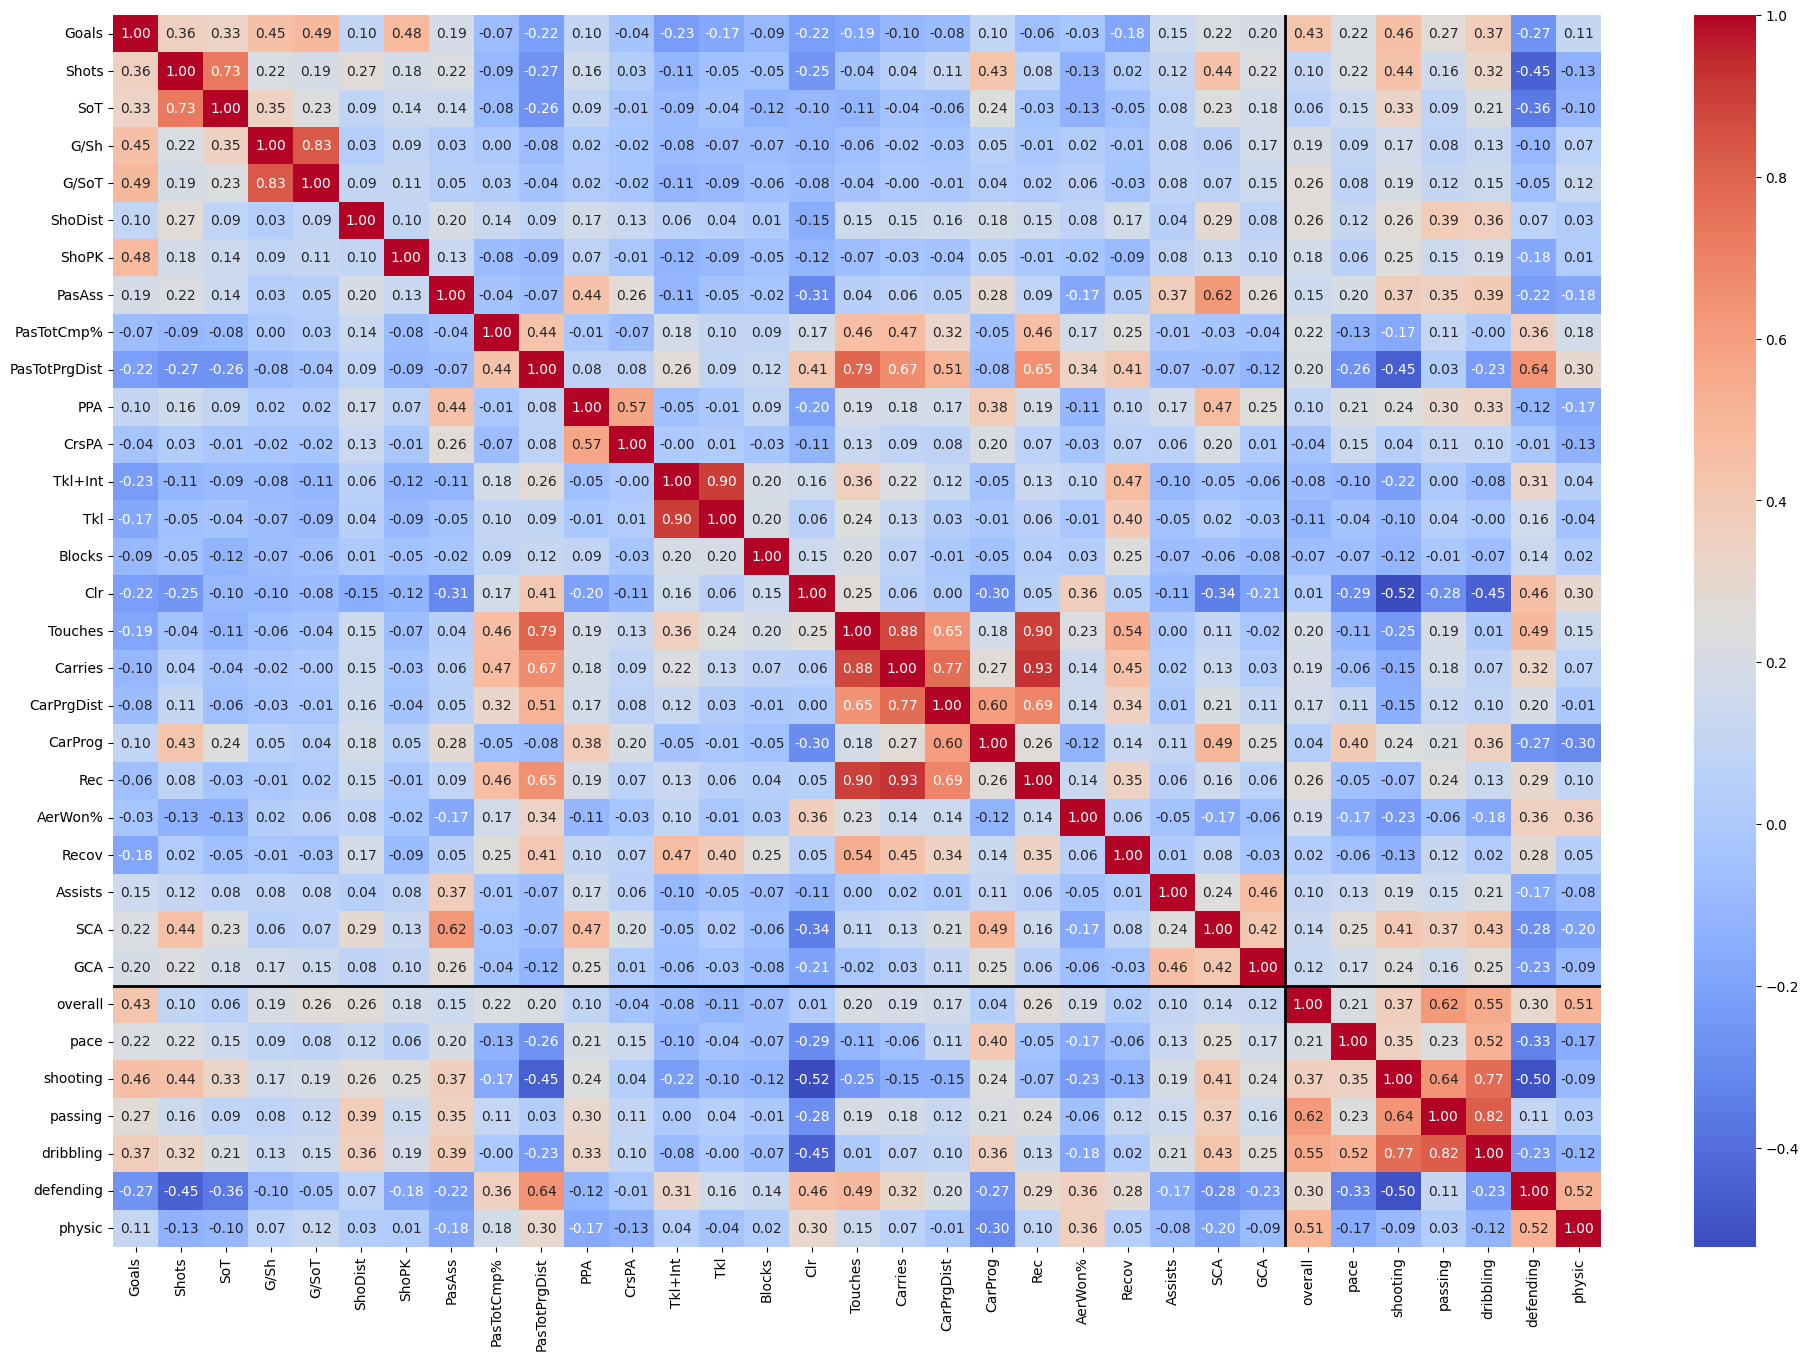

In [86]:
# visualize the correlation between the overall rating and the overall attribute

# Limiting the number of stats
stats_ft_list= ["Goals", "Shots", "SoT", "G/Sh", "G/SoT", "ShoDist", "ShoPK", "PasAss", "PasTotCmp%", "PasTotPrgDist", "PPA", "CrsPA", "Tkl+Int", "Tkl", "Blocks", "Clr", "Touches", "Carries", "CarPrgDist", "CarProg", "Rec", "AerWon%", "Recov", "Assists", "SCA", "GCA"]

# plot the correlation with the overall rating
plt.figure(figsize=(24, 16))
sns.heatmap(outfield_players[stats_ft_list + ['overall'] + ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']].corr(), annot=True, cmap='coolwarm', fmt=".2f")

# separate the stats_ft_list from the rest of the columns
plt.axhline(y=len(stats_ft_list), color='black', linewidth=2)
plt.axvline(x=len(stats_ft_list), color='black', linewidth=2)
plt.show()

This correlation matrix produces mostly predictable results, with **Goals** being the feature most correlated with **overall** and strongly correlated with **shooting**.

Attacking stats like **Goals** and **Shots** being negatively correlated with **defending** also makes sense.

## Outliers

Outliers in this dataset represent exceptional players like Lionel Messi and Cristiano Ronaldo which are natural and valuable insights rather than noise. Removing them would erase meaningful patterns like standout players or role-specific stats. We have decided to retain them and maybe use scaling methods like Min-Max or Robust Scaling to manage their impact while preserving the dataset's integrity.

## Feature Distributions

Visualize the distribution of each feature to understand its spread and detect outliers.

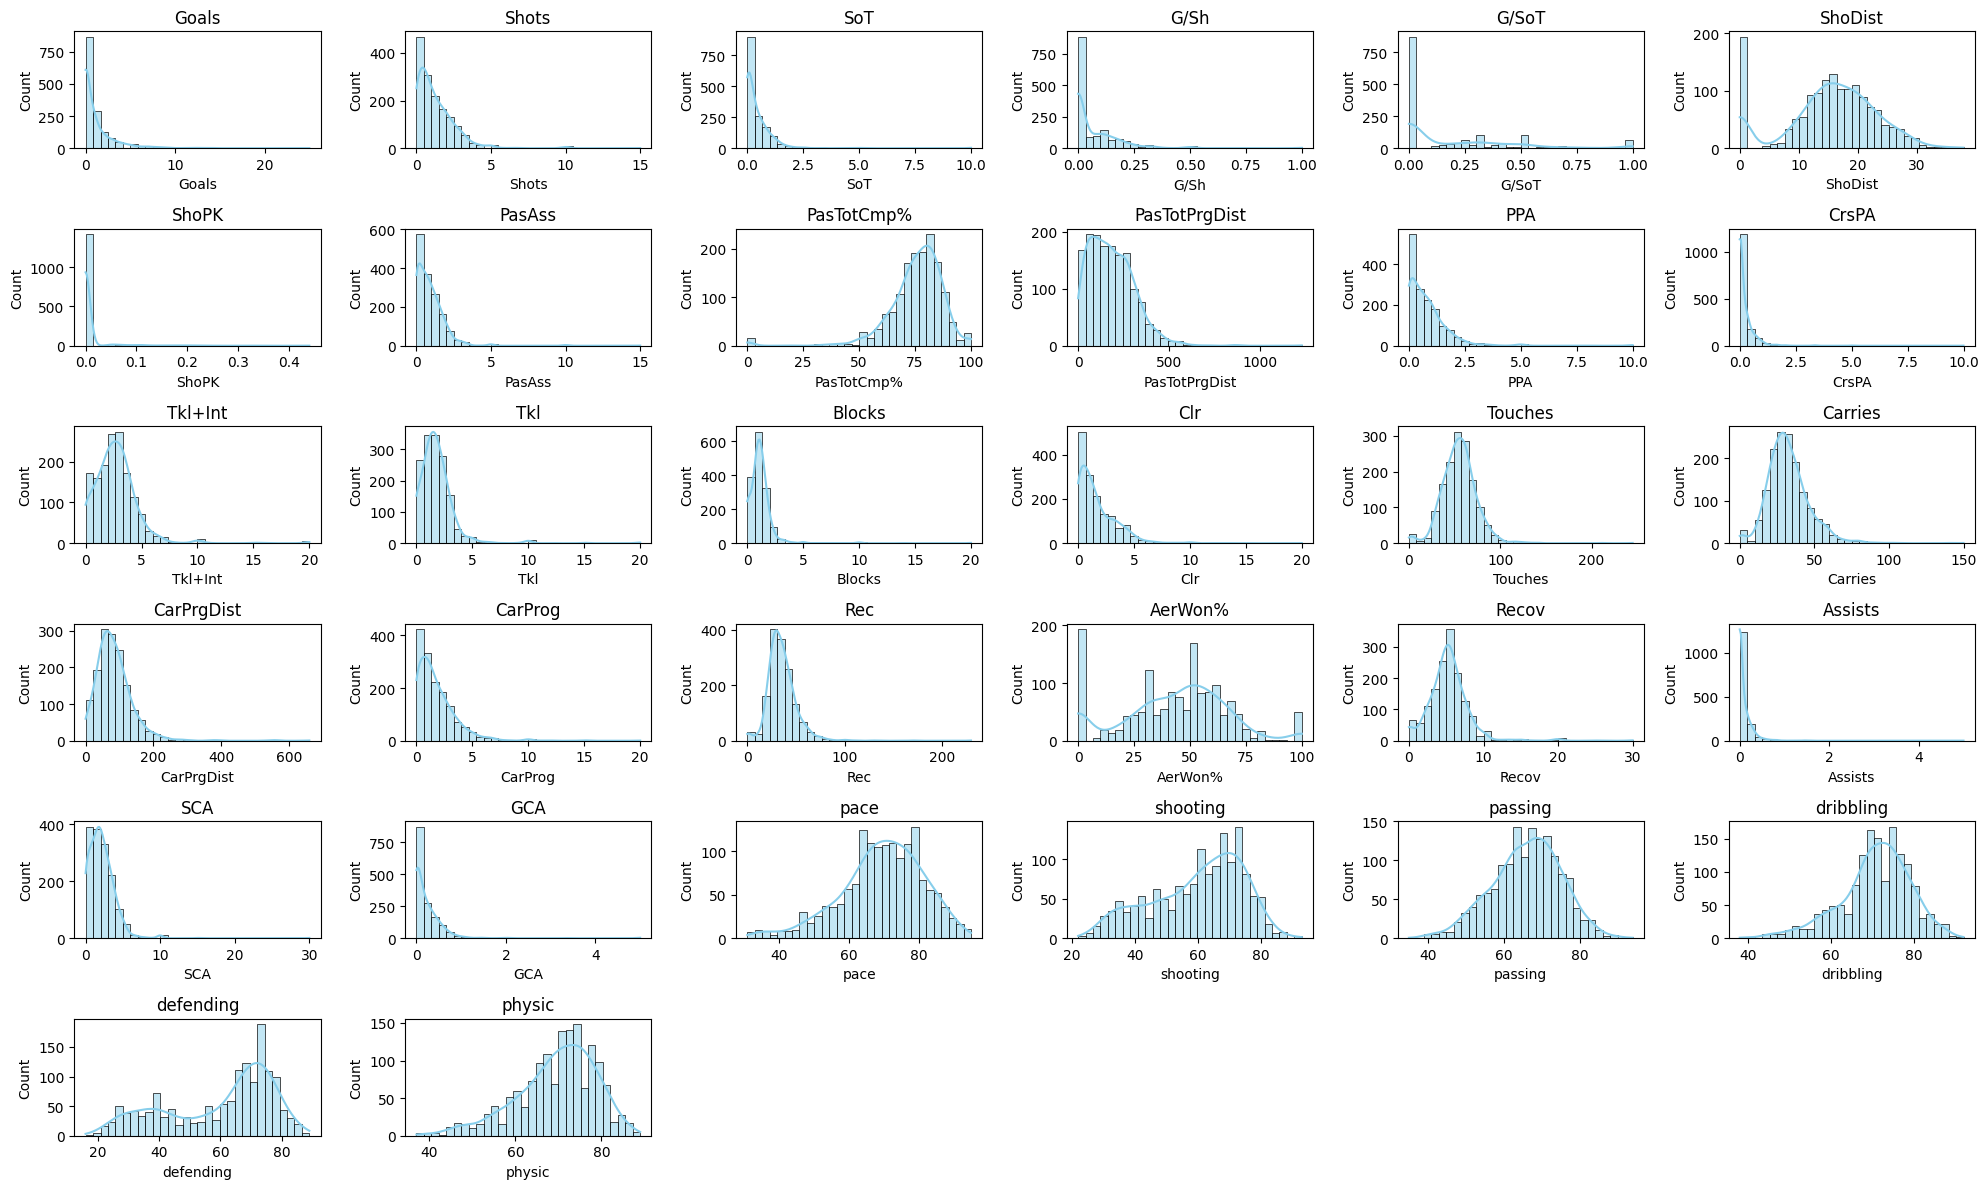

In [87]:
plt.figure(figsize=(20, 12))
for i, feature in enumerate(stats_ft_list + ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic'], start=1):
    plt.subplot(6, 6, i)  # Increase to 6 rows and 6 columns
    sns.histplot(outfield_players[feature], kde=True, bins=30, color='skyblue')
    plt.title(feature)
plt.tight_layout()
plt.show()

## Box Plots for Category Comparison

Compare overall ratings across different positional roles (position column if available) or physical attributes like AerWon%.

<ipython-input-135-59e2aeda83be>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Pos', y='overall', palette='Set2')


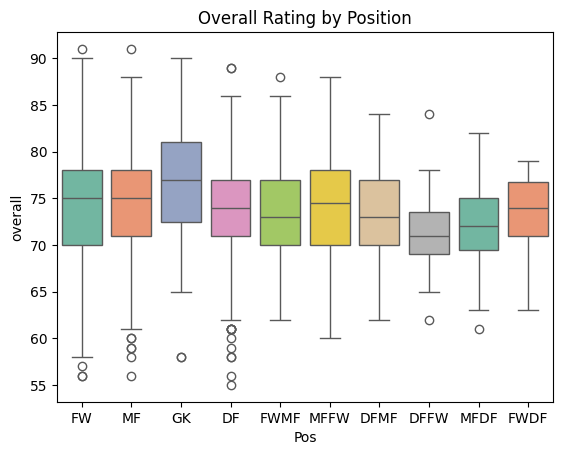

In [ ]:
sns.boxplot(data=merged, x='Pos', y='overall', palette='Set2')
plt.title('Overall Rating by Position')
plt.show()

## Radar Charts for Player Profiles

Visualize a player's overall attributes (e.g., pace, shooting, passing) in a radar chart.

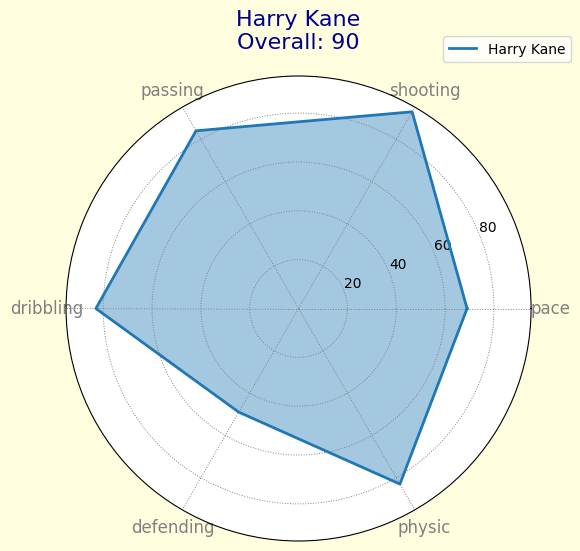

In [90]:
# Select player data
player = outfield_players.loc[outfield_players['Player'] == 'Harry Kane']
attributes = ['pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic']
values = player[attributes].values.flatten().tolist()
values += values[:1]  # Close the loop

# Overall rating
overall = player['overall'].values[0]  # Get the overall rating

# Calculate angles for radar chart
angles = [n / float(len(attributes)) * 2 * pi for n in range(len(attributes))]
angles += angles[:1]

# Create radar chart
plt.figure(figsize=(6, 8))  # Adjust figure size for FIFA card style
ax = plt.subplot(111, polar=True)

# Radar chart setup
plt.xticks(angles[:-1], attributes, color='grey', size=12)
ax.plot(angles, values, linewidth=2, linestyle='solid', label=player['Player'].values[0])
ax.fill(angles, values, alpha=0.4)

# FIFA card style enhancements
plt.title(f"{player['Player'].values[0]}\nOverall: {overall}", size=16, color='darkblue', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
ax.grid(color='grey', linestyle='dotted', linewidth=0.7)

# Add card background (optional)
plt.gcf().patch.set_facecolor('lightyellow')

plt.show()

# Linear Regression

We're now going to create our linear regression model pipeline. We're gonna start by using all the features and then testing with different features and parameters.

The sections **Merged** and **Goalkeepers** aren't what interest us. It's the section **Outfield** that does.

## Merged

In [91]:
# Drop target and unwanted columns
exclude_features = [
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes", "goalkeeping_speed", "Rk", "Born", "norm_name"
]

# Drop excluded columns
X = merged.drop(columns=exclude_features, errors="ignore")
y = merged["overall"]

# Keep only numeric features
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")


Mean Squared Error (MSE): 17.94
R^2 Score: 0.38


## Goalkeepers

In [92]:
# Drop target and unwanted columns
exclude_features = [
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes", "goalkeeping_speed", "Rk", "Born", "norm_name"
]

# Drop excluded columns
X = goalkeepers.drop(columns=exclude_features, errors="ignore")
y = goalkeepers["overall"]

# Keep only numeric features
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error (MSE): 180.32
R^2 Score: -3.23


## Outfield

### Using Numerical Features Only

In [ ]:
# Drop target and unwanted columns
exclude_features = [
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes", "goalkeeping_speed", "Rk", "Born", "norm_name"
]

# Drop excluded columns
X = outfield_players.drop(columns=exclude_features, errors="ignore")
y = outfield_players["overall"]

# Keep only numeric features
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error (MSE): 20.83
R^2 Score: 0.37

Cross-validation Results:
CV R^2 Scores: [ -4.30954598 -11.89734632 -18.89203783 -20.07731657  -4.93335358]
Mean CV R^2 Score: -12.02 (+/- 13.32)


### Using Both Numerical and Categorical Features

In our dataset we have the following categorical features:

['Player', 'Nation', 'Pos', 'Squad', 'Comp']

Player isn't a very meaningful feature, the other four however we want to keep as they may be significant. For example, for two players with the same stats, we would expect the one playing in a tougher league or **'Comp'** to have a better rating. So we shouldn't exclude these features.

This block also contains our full pipeline, from the column transformers that use **OneHotEncoder** for categorical features to the linear regression model and the cross-validation tests.

In [ ]:
# Drop target and unwanted columns
exclude_features = [
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking",
    "goalkeeping_positioning", "goalkeeping_reflexes", "goalkeeping_speed",
    "Rk", "Born", "norm_name", "norm_name_2", "Player"
]

# Drop excluded columns
X = outfield_players.drop(columns=exclude_features, errors="ignore", axis=1)
y = outfield_players["overall"]

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Define transformers for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),  # Keep numeric features unchanged
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ]
)

# Apply transformations
X_transformed = preprocessor.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Cross-validation
cv_scores = cross_val_score(model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()
cv_r2 = cross_val_score(model, X_transformed, y, cv=5, scoring='r2').mean()
print(f"Cross-validation Mean Squared Error (MSE): {cv_mse:.2f}")
print(f"Cross-validation R^2 Score: {cv_r2:.2f}")

Mean Squared Error (MSE): 17.53
R^2 Score: 0.47
Cross-validation Mean Squared Error (MSE): 28.54
Cross-validation R^2 Score: -12.02


### Scaling the Features with StandardScaler

In [94]:
# Drop target and unwanted columns
exclude_features = [
    "overall", "pace", "shooting", "passing", "dribbling", "defending", "physic",
    "goalkeeping_diving", "goalkeeping_handling", "goalkeeping_kicking", "goalkeeping_positioning",
    "goalkeeping_reflexes", "goalkeeping_speed", "Rk", "Born", "norm_name", "norm_name_2"
]

# Drop excluded columns
X = outfield_players.drop(columns=exclude_features, errors="ignore", axis=1)
y = outfield_players["overall"]

# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

# Define transformers for numeric and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),  # Scale numeric features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Apply transformations
X_transformed = preprocessor.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on test set
y_pred = model.predict(X_test)

# Metrics for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform cross-validation
cv_mse = -cross_val_score(model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')  # Negative MSE (convert to positive)
cv_r2 = cross_val_score(model, X_transformed, y, cv=5, scoring='r2')

# Print results
print(f"Test Set Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}\n")

print(f"Cross-Validation Metrics:")
print(f"Mean MSE (Cross-Validation): {np.mean(cv_mse):.2f} (+/- {np.std(cv_mse):.2f})")
print(f"Mean R^2 Score (Cross-Validation): {np.mean(cv_r2):.2f} (+/- {np.std(cv_r2):.2f})")

Test Set Metrics:
Mean Squared Error (MSE): 14.81
R^2 Score: 0.55

Cross-Validation Metrics:
Mean MSE (Cross-Validation): 25.97 (+/- 19.64)
Mean R^2 Score (Cross-Validation): -9.92 (+/- 4.94)


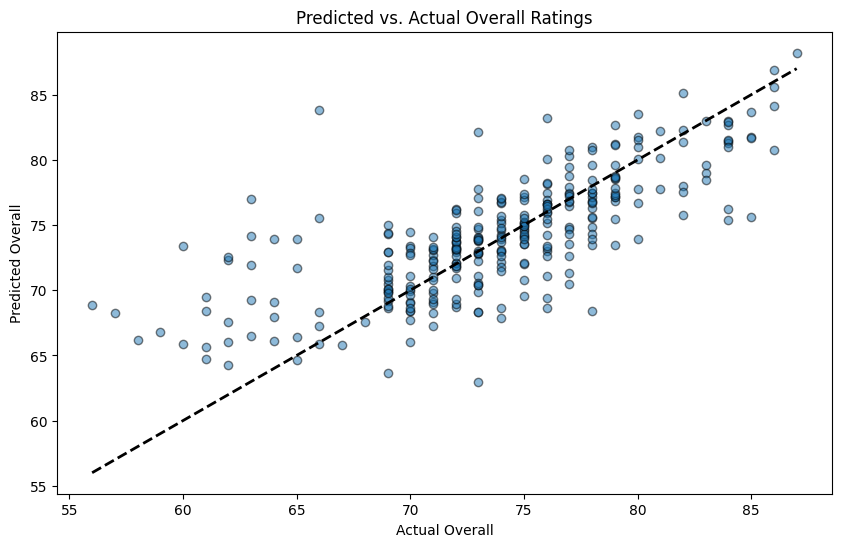

In [ ]:
# Get actual and predicted overall ratings for all players
y_pred = model.predict(X_test)
actual_overalls = y_test.values

# Create a simple scatter plot with a line plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_overalls, y_pred, alpha=0.5, edgecolors=(0, 0, 0))

# Plot the line y = x (perfect prediction line)
plt.plot([actual_overalls.min(), actual_overalls.max()],
         [actual_overalls.min(), actual_overalls.max()], 'k--', lw=2)

plt.xlabel('Actual Overall')
plt.ylabel('Predicted Overall')
plt.title('Predicted vs. Actual Overall Ratings')
plt.show()

## Limiting the number of features

Since our dataset has a lot of features (100+) and not many instances (~1500) maybe we should try to limit the number of featres we use for our model.


In [95]:
# Define the features to use for the model
stats_ft_list = [
    "Goals", "Shots", "SoT", "G/Sh", "G/SoT", "ShoDist", "ShoPK", "PasAss",
    "PasTotCmp%", "PasTotPrgDist", "PPA", "CrsPA", "Tkl+Int", "Tkl", "Blocks",
    "Clr", "Touches", "Carries", "CarPrgDist", "CarProg", "Rec", "AerWon%",
    "Recov", "Assists", "SCA", "GCA"
]

# Select only the specified features and the target
X = outfield_players[stats_ft_list]
y = outfield_players["overall"]

# Keep only numeric features (in case there are any non-numeric columns)
X_numeric = X.select_dtypes(include=["float64", "int64"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict the target values for the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics for the test set
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Perform cross-validation
cv_mse = -cross_val_score(model, X_numeric, y, cv=5, scoring='neg_mean_squared_error')  # Negative MSE (convert to positive)
cv_r2 = cross_val_score(model, X_numeric, y, cv=5, scoring='r2')

# Print results
print(f"Test Set Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R^2 Score: {r2:.2f}\n")

print(f"Cross-Validation Metrics:")
print(f"Mean MSE (Cross-Validation): {np.mean(cv_mse):.2f} (+/- {np.std(cv_mse):.2f})")
print(f"Mean R^2 Score (Cross-Validation): {np.mean(cv_r2):.2f} (+/- {np.std(cv_r2):.2f})")


Test Set Metrics:
Mean Squared Error (MSE): 23.32
R^2 Score: 0.29

Cross-Validation Metrics:
Mean MSE (Cross-Validation): 33.55 (+/- 28.84)
Mean R^2 Score (Cross-Validation): -10.38 (+/- 3.69)


Linear models often struggle with complex datasets because they assume a linear relationship between the features and the target variable. In this case, the data likely contains non-linear patterns and interactions between features that a simple linear regression model cannot capture.

Approaches like decision trees or random forests are better suited for such scenarios, as they can model non-linear relationships and interactions more effectively. So in the next sections, we will explore these techniques to improve performance.








#Decision Tree

##Using Numerical Features Only

In [ ]:
# Use the same X_numeric and y from Linear Regression code
# (Assume X_numeric and y are already defined)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42, max_depth=10)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree - Mean Squared Error (MSE): {mse:.2f}")
print(f"Decision Tree - R^2 Score: {r2:.2f}")


Decision Tree - Mean Squared Error (MSE): 40.62
Decision Tree - R^2 Score: -0.24


### Hyperparameter Optimization for Decision Tree Using GridSearchCV

In [ ]:
# Define parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid Search
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model
best_dt_model = grid_search.best_estimator_

# Evaluate
y_pred_best = best_dt_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

print(f"Tuned Decision Tree - MSE: {best_mse:.2f}, R^2: {best_r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

Tuned Decision Tree - MSE: 23.36, R^2: 0.29
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10}


## Using Both Numerical and Categorical Features

In [ ]:
# Use the same X_transformed and y from Linear Regression code


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree - Mean Squared Error (MSE): {mse:.2f}")
print(f"Decision Tree - R^2 Score: {r2:.2f}")

Decision Tree - Mean Squared Error (MSE): 19.02
Decision Tree - R^2 Score: 0.42


We noticed that incorporating both numerical and categorical features led to better results. By including categorical variables like "Squad", we provide the model with more comprehensive information.

#Random Forest

##Using Numerical Features Only

In [99]:
# Split the data (if already done, you can skip this step)
X_trainRFT, X_testRFT, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_trainRFT, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_testRFT)

# Calculate performance metrics for the test set
mse_rf = mean_squared_error(y_test, y_pred_rf)  # Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)  # R-squared score

# Cross-validation
cv_mse = -cross_val_score(rf_model, X_transformed, y, cv=5, scoring='neg_mean_squared_error')
cv_r2 = cross_val_score(rf_model, X_transformed, y, cv=5, scoring='r2')

# Output results
print(f"Random Forest - Test Set Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest - Test Set R^2 Score: {r2_rf:.2f}")
print(f"Cross-Validation Mean Squared Error (MSE): {np.mean(cv_mse):.2f} (+/- {np.std(cv_mse):.2f})")
print(f"Cross-Validation R^2 Score: {np.mean(cv_r2):.2f} (+/- {np.std(cv_r2):.2f})")


Random Forest - Test Set Mean Squared Error (MSE): 13.55
Random Forest - Test Set R^2 Score: 0.59
Cross-Validation Mean Squared Error (MSE): 30.26 (+/- 25.59)
Cross-Validation R^2 Score: -9.18 (+/- 2.97)


###Hyperparameter Tuning for Random Forest Using Pipeline and GridSearchCV

In [ ]:
# Create a pipeline with preprocessing and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize the features
    ('model', RandomForestRegressor())  # Random Forest Regressor as the model
])

# Define the hyperparameters to tune
param_grid = {
    'model__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'model__max_depth': [5, 10, None],  # Maximum depth of the tree
    'model__min_samples_split': [2, 5],  # Minimum number of samples required to split an internal node
    'model__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='neg_mean_squared_error')

# Train the model using GridSearchCV
grid_search.fit(X_trainRFNum, y_train)

# Results of the best model
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score (MSE): {-grid_search.best_score_}")


Best Parameters: {'model__max_depth': 10, 'model__min_samples_leaf': 4, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Best Score (MSE): 18.060651874749528


### Parallel Coordinates Plot

<ipython-input-170-80509ff11aa5>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0     0.000000
1     0.333333
2     1.000000
3     0.000000
4     0.333333
5     1.000000
6     0.000000
7     0.333333
8     1.000000
9     0.000000
10    0.333333
11    1.000000
12    0.000000
13    0.333333
14    1.000000
15    0.000000
16    0.333333
17    1.000000
18    0.000000
19    0.333333
20    1.000000
21    0.000000
22    0.333333
23    1.000000
24    0.000000
25    0.333333
26    1.000000
27    0.000000
28    0.333333
29    1.000000
30    0.000000
31    0.333333
32    1.000000
33    0.000000
34    0.333333
35    1.000000
36    0.000000
37    0.333333
38    1.000000
39    0.000000
40    0.333333
41    1.000000
42    0.000000
43    0.333333
44    1.000000
45    0.000000
46    0.333333
47    1.000000
48    0.000000
49    0.333333
50    1.000000
51    0.000000
52    0.333333
53    1.000000
Name: n_estimators, dtype: float64'

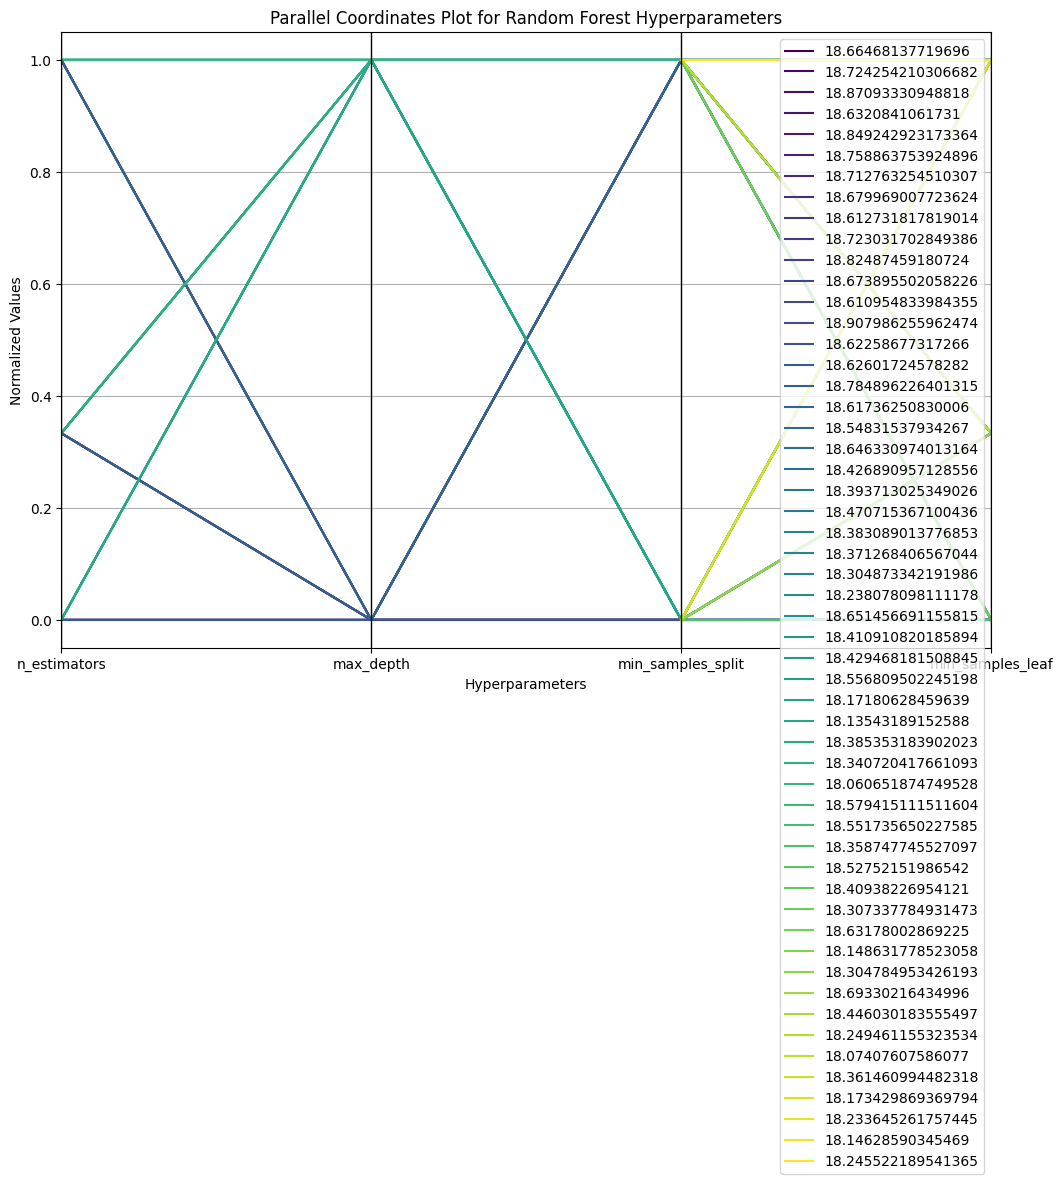

In [ ]:
# Get the results from GridSearchCV
results = grid_search.cv_results_

# Create a DataFrame from the results
df_results = pd.DataFrame({
    'n_estimators': [params['model__n_estimators'] for params in results['params']],
    'max_depth': [params['model__max_depth'] for params in results['params']],
    'min_samples_split': [params['model__min_samples_split'] for params in results['params']],
    'min_samples_leaf': [params['model__min_samples_leaf'] for params in results['params']],
    'mean_test_score': -results['mean_test_score']  # Convert to positive MSE
})

# Normalize the hyperparameters for the plot
df_normalized = df_results.copy()
df_normalized.iloc[:, :-1] = (df_results.iloc[:, :-1] - df_results.iloc[:, :-1].min()) / \
                             (df_results.iloc[:, :-1].max() - df_results.iloc[:, :-1].min())

# Add a column for coloring (based on performance)
df_normalized['mean_test_score'] = df_results['mean_test_score']

# Plot the parallel coordinates graph
plt.figure(figsize=(12, 8))
parallel_coordinates(df_normalized, 'mean_test_score', colormap='viridis')

# Customize the plot
plt.title("Parallel Coordinates Plot for Random Forest Hyperparameters")
plt.xlabel("Hyperparameters")
plt.ylabel("Normalized Values")
plt.grid(True)
plt.show()


##Using Both Numerical and Categorical Features

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split the data (if already done, you can skip this step)
X_trainRFT, X_testRFT, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Fit the model to the training data
rf_model.fit(X_trainRFT, y_train)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_testRFT)

# Calculate performance metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)  # Mean Squared Error
r2_rf = r2_score(y_test, y_pred_rf)  # R-squared score

print(f"Random Forest - Mean Squared Error (MSE): {mse_rf:.2f}")
print(f"Random Forest - R^2 Score: {r2_rf:.2f}")

Cross-Validation Results:
Mean MSE: 18.48 (+/- 1.92)
Mean R² Score: 0.42 (+/- 0.08)

Test Set Results:
Random Forest - Mean Squared Error (MSE): 19.25
Random Forest - R^2 Score: 0.41


Random Forest generally gives better results compared to Decision Tree and Linear Regression.

# Gradient Boosting

In [ ]:
# Initialize the Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=42)
X_trainGB, X_testGB, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Fit the model
gb_model.fit(X_trainGB, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_testGB)

# Calculate performance metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting - Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"Gradient Boosting - R^2 Score: {r2_gb:.2f}")

Gradient Boosting - Mean Squared Error (MSE): 12.87
Gradient Boosting - R^2 Score: 0.61


We used this model with both numerical and categorical features, and it gave the best results among all the models we used.